In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pstats
from sklearn.linear_model import LinearRegression

# Code profiles of NCMC
**Comparing timings 2 propagation kernels: velocity Verlet and GHMC**

The timings are for a salt insertion attempt in a $20 \times 20 \times 20 \text{ Angs.}^3$ periodic box of TIP3P water. Long range electrostatics treated with PME with a 9 Angs. cutoff. The water box was made with `openmmtools` `WaterBox` test system with the default switching function for LJ interactions.

Every insertion used 100 perturbation steps, different numbers of MD propagation steps were explored.

* Integrators were taken from `openmmtools 0.8.0 dev`, and simulations were run with `openmm 7.0.1`
* All simulations run with `gtxtitans`

## Timings for 100 perturbation kernels, 1 propagation kernel for each perturbation

Reading in data:

In [2]:
repeats = 3

totaltime_ghmc = []
updateforce_ghmc = []
getenergy_ghmc = []
updateparmscont_ghmc = []
setparams_ghmc = []
ncmc_ghmc = []
step_ghmc = []

totaltime_vv = []
updateforce_vv = []
getenergy_vv = []
updateparmscont_vv = []
setparams_vv = []
ncmc_vv = []
step_vv = []

# GHMC
for rep in range(repeats):
    filename = "GHMC/profile{0}_npert100_nprop1".format(rep)
    p = pstats.Stats(filename)
    p.strip_dirs()
    p.sort_stats('cumulative')
    totaltime_ghmc.append(p.stats[('<string>', 1, '<module>')][3])
    updateforce_ghmc.append(p.stats[('saltswap.py', 550, 'updateForces_fractional')][3] )
    getenergy_ghmc.append(p.stats[('saltswap.py', 320, 'getPotEnergy')][3])
    updateparmscont_ghmc.append(p.stats[('openmm.py', 8444, 'updateParametersInContext')][3])
    setparams_ghmc.append(p.stats[('openmm.py', 8275, 'setParticleParameters')][3])
    ncmc_ghmc.append(p.stats[('saltswap.py', 461, 'NCMC')][3])
    step_ghmc.append(p.stats[('openmm.py', 15000, 'step')][3])
totaltime_ghmc = np.array(totaltime_ghmc).mean()

# velocity Verlet
for rep in range(repeats):
    filename = "velocityVerlet/profile{0}_npert100_nprop1".format(rep)
    p = pstats.Stats(filename)
    p.strip_dirs()
    p.sort_stats('cumulative')
    totaltime_vv.append(p.stats[('<string>', 1, '<module>')][3])
    updateforce_vv.append(p.stats[('saltswap.py', 550, 'updateForces_fractional')][3] )
    getenergy_vv.append(p.stats[('saltswap.py', 320, 'getPotEnergy')][3])
    updateparmscont_vv.append(p.stats[('openmm.py', 8444, 'updateParametersInContext')][3])
    setparams_vv.append(p.stats[('openmm.py', 8275, 'setParticleParameters')][3])
    ncmc_vv.append(p.stats[('saltswap.py', 461, 'NCMC')][3])
    step_vv.append(p.stats[('openmm.py', 15000, 'step')][3])
totaltime_vv = np.array(totaltime_vv).mean()

#print 'Total time for using GHMC = {0}s, Total time for vV = {1}s'.format(round(totaltime_ghmc,2),round(totaltime_vv,2))

Table showing the main differences between the NCMC steps with GHMC and velocity Verlet. The differences are solely due to the longer time it takes for an MD step and the increased number of energy calls to keep track of the accumulated work.

As a control, some functions that should be the same between the two integrators has been added.

In [2]:
print 'Timings for each stage/function for a single insertion/deletion attempt with 100 perturbation kernels, with 1 single MD step per perturbation\n'
print 'Highlighting the differences first, followed by timings that should be the same between the two integrators.\n'
print '                      | GHMC     | velocity Verlet'
print '--------------------------------------------------'
print 'Total time            | {0:f} | {1:f}'.format(np.array(totaltime_ghmc).mean(),np.array(totaltime_vv).mean())
print 'NCMC function         | {0:f} | {1:f}'.format(np.array(ncmc_ghmc).mean(),np.array(ncmc_vv).mean())
print 'MD step               | {0:f} | {1:f}'.format(np.array(step_ghmc).mean(),np.array(step_vv).mean())
print 'Get potential energy  | {0:f} | {1:f}'.format(np.array(getenergy_ghmc).mean(),np.array(getenergy_vv).mean())
print '--------------------------------------------------'
print 'updateParamsInContext | {0:f} | {1:f}'.format(np.array(updateparmscont_ghmc).mean(),np.array(updateparmscont_vv).mean())
print 'updateForces          | {0:f} | {1:f}'.format(np.array(updateforce_ghmc).mean(),np.array(updateforce_vv).mean())
print 'setParticleParameters | {0:f} | {1:f}'.format(np.array(setparams_ghmc).mean(),np.array(setparams_vv).mean())

Timings for each stage/function for a single insertion/deletion attempt with 100 perturbation kernels, with 1 single MD step per perturbation

Highlighting the differences first, followed by timings that should be the same between the two integrators.

                      | GHMC     | velocity Verlet
--------------------------------------------------


NameError: name 'np' is not defined

Comments here

THESE ARE FOR 100 PERTURBATION KERNELS



Maybe all the overhead is in updateForces. It's roughly half the amount of time in velocity Verlet, and the calculation of the interpolated parametes seems to take a long time. Also, the LJ parameters of the hydrogens don't need to be updated.

**Recomendations**
* Precalculate interpolated parameter values in `updateForeces`. May be able to speed up function by a factor of around 2.5
* Do not set the L.J. parameters of the hydrogens, as already 0.

Overhead is due to `updateForces`, which calls `setParticleParameters`. Separately, overhead is due to `updateParametersInContext`, which is called by NCMC. Finally, there is overhead for first MD step of the propagator.

In [13]:
# For GHMC:
overhead = 0.131/100 + 0.057909/100 + 0.00029

In [18]:
print 'So for 8000 perturbation steps, the takes a total of {0:f}s per insertion/deletion attempt'.format(overhead*8000)

So for 8000 perturbation steps, the takes a total of 17.432720s per insertion/deletion attempt


# Overheads in openmm's step

In [4]:
repeats = 3

step_ghmc = []
step_vv = []

# GHMC
for nsteps in range(1,11):
    temp = []
    for rep in range(repeats):
        filename = "GHMC/profile{0}_npert100_nprop{1}".format(rep,nsteps)
        p = pstats.Stats(filename)
        p.strip_dirs()
        p.sort_stats('cumulative')
        temp.append(p.stats[('openmm.py', 15000, 'step')][3])   
    step_ghmc.append(np.array(temp).mean())
# velocity Verlet
for nsteps in range(1,11):
    temp = []
    for rep in range(repeats):
        filename = "velocityVerlet/profile{0}_npert100_nprop{1}".format(rep,nsteps)
        p = pstats.Stats(filename)
        p.strip_dirs()
        p.sort_stats('cumulative')
        temp.append(p.stats[('openmm.py', 15000, 'step')][3])   
    step_vv.append(np.array(temp).mean())

step_ghmc = np.array(step_ghmc)
step_vv = np.array(step_vv)

/Users/rossg/miniconda2/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


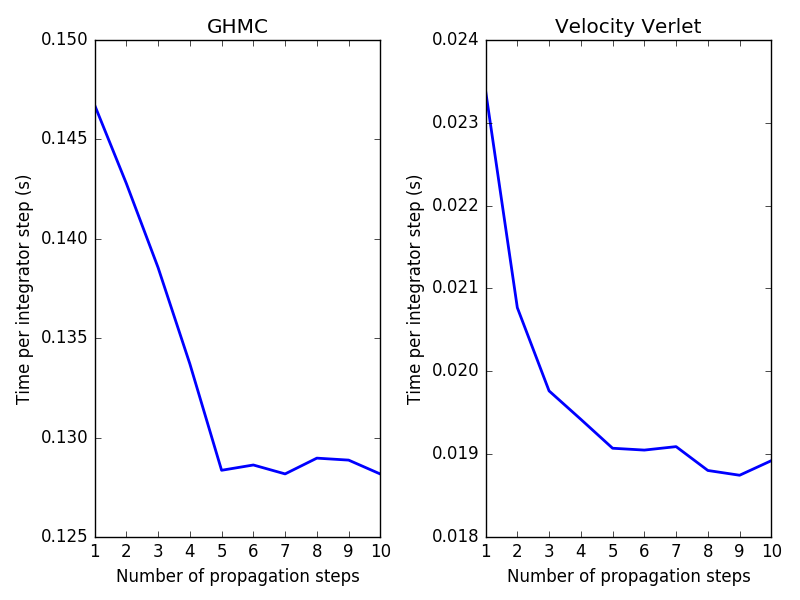

In [5]:
nsteps = np.array(range(1,11))

plt.clf()
fig, axarr = plt.subplots(1, 2)

nsteps = np.array(range(1,11))
# GHMC
axarr[0].plot(nsteps,step_ghmc/nsteps,linewidth=2)
axarr[0].set_xlabel('Number of propagation steps')
axarr[0].set_ylabel('Time per integrator step (s)')
axarr[0].set_title('GHMC')
# velocity Verlet
axarr[1].plot(nsteps,step_vv/nsteps,linewidth=2)
axarr[1].set_xlabel('Number of propagation steps')
axarr[1].set_ylabel('Time per integrator step (s)')
axarr[1].set_title('Velocity Verlet')

plt.tight_layout()
plt.savefig('temp.png',format='png')
Image("temp.png")

$$ T = tn + c $$

I'M MISSING THE NUMBER OF PERTURBATIONS. There are in fact 100 perturbations, so divide offset by 100.

In [6]:
npert = 100.0 # The number of perturbations
T_ghmc = step_ghmc.reshape(len(step_ghmc),1)/npert
T_vv = step_vv.reshape(len(step_vv),1)/npert
n = nsteps.reshape(len(nsteps),1)

regr_ghmc = LinearRegression()
regr_ghmc.fit(n,T_ghmc)

print 'Time taken for a single GHMC step = {0}s'.format(round(regr_ghmc.coef_[0][0],6))
print '    Overhead for first step = {0}s\n'.format(round(regr_ghmc.intercept_,6))

regr_vv = LinearRegression()
regr_vv.fit(n,T_vv)

print 'Time taken for a single velocity Verlet step = {0}s'.format(round(regr_vv.coef_[0][0],6))
print '    Overhead for first step = {0}s\n'.format(round(regr_vv.intercept_,6))

Time taken for a single GHMC step = 0.00125s
    Overhead for first step = 0.00029s

Time taken for a single velocity Verlet step = 0.000183s
    Overhead for first step = 4.5e-05s



In [12]:
0.00029*4000

1.16

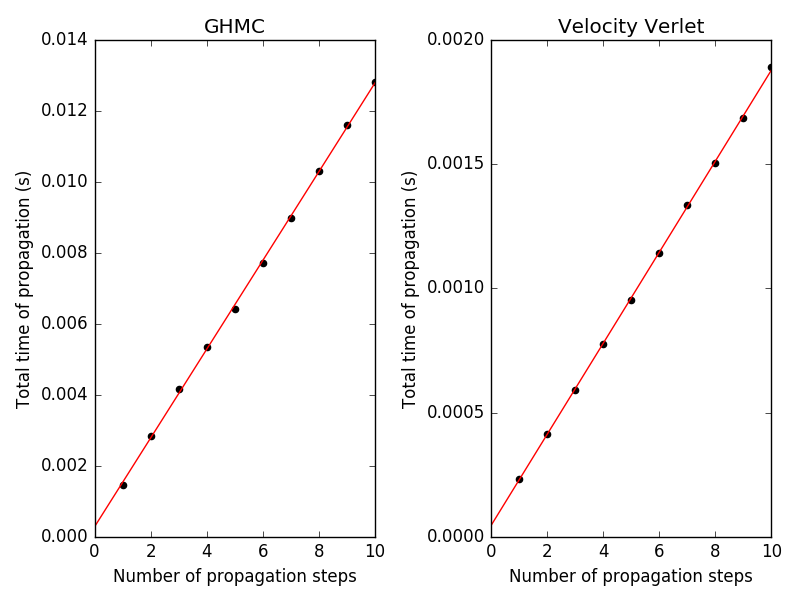

In [11]:
nsteps = np.array(range(1,11))

plt.clf()
fig, axarr = plt.subplots(1, 2)

nsteps = np.array(range(1,11))
x = np.linspace(0,10)
y_ghmc = regr_ghmc.predict(x.reshape(len(x),1))
y_vv= regr_vv.predict(x.reshape(len(x),1))

#y_ghmc= y_ghmc[:,0]
#print regr_ghmc.predict(x.reshape(len(x),1))

# GHMC
axarr[0].plot(x,y_ghmc,color='red')
axarr[0].scatter(nsteps,T_ghmc,color='k')
axarr[0].set_xlim((0,10))
axarr[0].set_ylim((0,0.014))
axarr[0].set_xlabel('Number of propagation steps')
axarr[0].set_ylabel('Total time of propagation (s)')
axarr[0].set_title('GHMC')
# velocity Verlet
axarr[1].plot(x,y_vv,color='red')
axarr[1].scatter(nsteps,T_vv,color='k')
axarr[1].set_xlim((0,10))
axarr[1].set_ylim((0,0.002))
axarr[1].set_xlabel('Number of propagation steps')
axarr[1].set_ylabel('Total time of propagation (s)')
axarr[1].set_title('Velocity Verlet')

plt.tight_layout()
plt.savefig('temp.png',format='png')
Image("temp.png")

In [41]:
nsteps = np.array(range(1,11))

plt.clf()
fig, axarr = plt.subplots(1, 2)

nsteps = np.array(range(1,11))
# GHMC
axarr[0].plot(nsteps,step_ghmc,linewidth=2)
axarr[0].set_xlabel('Number of propagation steps')
axarr[0].set_ylabel('Total time of propagation (s)')
axarr[0].set_title('GHMC')
# velocity Verlet
axarr[1].plot(nsteps,step_vv,linewidth=2)
axarr[1].set_xlabel('Number of propagation steps')
axarr[1].set_ylabel('Total time of propagation (s)')
axarr[1].set_title('Velocity Verlet')

plt.tight_layout()
plt.savefig('temp.png',format='png')
Image("temp.png")

115.828

In [43]:
0.125039/0.018334

6.820061088687685

In [128]:
filename = "GHMC/profile1_npert100_nprop1"       # The name of the output from profile
number=30                   # The number of functions whose times will be printed out
p = pstats.Stats(filename)
p.strip_dirs()
p.sort_stats('cumulative').print_stats(number)       # Printing my total time spent with function

Thu Aug 25 16:14:35 2016    GHMC/profile1_npert100_nprop1

         223768 function calls (223364 primitive calls) in 0.492 seconds

   Ordered by: cumulative time
   List reduced from 87 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.492    0.492 <string>:1(<module>)
        1    0.000    0.000    0.492    0.492 time_ncmc.py:48(profile_move)
        1    0.000    0.000    0.492    0.492 calibrate.py:141(move)
        1    0.000    0.000    0.492    0.492 calibrate.py:126(gen_label)
        1    0.000    0.000    0.492    0.492 saltswap.py:658(update)
        1    0.000    0.000    0.491    0.491 saltswap.py:340(attempt_identity_swap)
        1    0.002    0.002    0.477    0.477 saltswap.py:461(NCMC)
      200    0.001    0.000    0.147    0.001 saltswap.py:320(getPotEnergy)
      102    0.000    0.000    0.141    0.001 openmm.py:15000(step)
      102    0.141    0.001    0.141    0.001 {_openmm.C

<pstats.Stats instance at 0x10e8e55a8>

In [14]:
filename = "velocityVerlet/profile0_npert100_nprop1"       # The name of the output from profile
number=30                   # The number of functions whose times will be printed out
p = pstats.Stats(filename)
p.strip_dirs()
p.sort_stats('cumulative').print_stats(number)       # Printing my total time spent with function

Thu Aug 25 12:29:05 2016    velocityVerlet/profile0_npert100_nprop1

         208033 function calls (208019 primitive calls) in 0.239 seconds

   Ordered by: cumulative time
   List reduced from 116 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.239    0.239 <string>:1(<module>)
        1    0.000    0.000    0.239    0.239 time_ncmc.py:48(profile_move)
        1    0.000    0.000    0.239    0.239 calibrate.py:141(move)
        1    0.000    0.000    0.239    0.239 calibrate.py:126(gen_label)
        1    0.000    0.000    0.239    0.239 saltswap.py:658(update)
        1    0.000    0.000    0.239    0.239 saltswap.py:340(attempt_identity_swap)
        1    0.001    0.001    0.221    0.221 saltswap.py:461(NCMC)
      100    0.007    0.000    0.131    0.001 saltswap.py:550(updateForces_fractional)
     7205    0.013    0.000    0.066    0.000 quantity.py:661(_change_units_with_factor)
      100    

<pstats.Stats instance at 0x10b973128>

In [11]:
filename = "velocityVerlet/profile2_npert100_nprop1"       # The name of the output from profile
number=30                   # The number of functions whose times will be printed out
p = pstats.Stats(filename)
p.strip_dirs()
p.sort_stats('cumulative').print_stats(number)       # Printing my total time spent with function

Thu Aug 25 16:23:07 2016    velocityVerlet/profile2_npert100_nprop1

         201006 function calls (200998 primitive calls) in 0.226 seconds

   Ordered by: cumulative time
   List reduced from 88 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.226    0.226 <string>:1(<module>)
        1    0.000    0.000    0.226    0.226 time_ncmc.py:48(profile_move)
        1    0.000    0.000    0.226    0.226 calibrate.py:141(move)
        1    0.000    0.000    0.226    0.226 calibrate.py:126(gen_label)
        1    0.000    0.000    0.226    0.226 saltswap.py:658(update)
        1    0.000    0.000    0.226    0.226 saltswap.py:340(attempt_identity_swap)
        1    0.001    0.001    0.211    0.211 saltswap.py:461(NCMC)
      101    0.009    0.000    0.131    0.001 saltswap.py:550(updateForces_fractional)
     7278    0.013    0.000    0.065    0.000 quantity.py:661(_change_units_with_factor)
      101    0

<pstats.Stats instance at 0x10ae88cb0>